## 1. Connexion à la base de données

In [8]:
import pandas as pd
import database
import matplotlib.pyplot as plt
import seaborn as sns

df = database.main()
df.drop_duplicates(keep='first', inplace=True)
# Load keywords from a CSV file without headers
keywords_df = pd.read_csv('skills.csv', header=None)  # Replace 'keywords.csv' with your file path
keyword_list = keywords_df[0].tolist()

# Function to find keywords in the description
def find_keywords(description, keywords):
    return [keyword for keyword in keywords if keyword in description]

# Apply the function to create the new column
df['skills'] = df['description'].apply(lambda desc: find_keywords(desc, keyword_list))
print(df.head)

<bound method NDFrame.head of                                                  title          company  \
0                              Data Analyst internship     PGBPGNGLOBAL   
1                              Senior Data Analyst H/F            Qonto   
2                                         Data Analyst             Jump   
3                                         Data analyst          Oh BiBi   
4                                 Product Data Analyst        leboncoin   
...                                                ...              ...   
1024                               Analyste de données            Cubyn   
1025                          Product Data Analyst F/H        Leboncoin   
1026                                      Data Analyst         Peroptyx   
1027  [INTERNSHIP] Generative AI Intern Data Scientist  Publicis Groupe   
1028                                    Data Scientist        Carrefour   

                                            description            lo

In [9]:
import re

# Function to parse and standardize salary
def standardize_salary(salary):
    if salary is None:
        return None
    
    # Find all numbers in the salary string
    numbers = [float(num.replace('K', '000')) for num in re.findall(r'[\d.]+K?|[\d,]+', salary.replace(',', ''))]
    
    # Determine the salary period and calculate annual salary
    if 'a month' in salary:
        annual_salary = sum(numbers) / len(numbers) * 12  # Average if a range, then convert to annual
    elif 'a day' in salary:
        annual_salary = sum(numbers) / len(numbers) * 220  # Average if a range, then convert to annual
    elif 'a year' in salary:
        annual_salary = sum(numbers) / len(numbers)  # Average if a range
    else:
        annual_salary = None  # Undefined period
    
    return annual_salary

# Apply the function to each salary
df['salary_standardized'] = [standardize_salary(s) for s in df.salary]

df_salary = df[df['salary_standardized'].notnull()]
# Filter rows where 'employment_type' contains 'Full-time'
df_filtered = df_salary[df_salary['employment_type'].str.contains('Full-time', case=False, na=False)]

## 2. Salaire median pour les 5 compétences les plus demandées

In [13]:
# Explode the 'skills' column
df_exploded = df.explode('skills')

# Calculate the median salary for each skill
median_salaries = df_exploded.groupby('skills')['salary_standardized'].median()

# Count the occurrences of each skill to find the top 5
top_skills = df_exploded['skills'].value_counts().head(5).index

# Filter the median salaries for the top 5 skills
top_skills_median_salaries = median_salaries[median_salaries.index.isin(top_skills)].sort_values(ascending=False)

print("Median Salary of the Top 5 Skills:")
print(top_skills_median_salaries)

Median Salary of the Top 5 Skills:
skills
go       85375.0
c        55000.0
r        55000.0
excel    42000.0
visio    13000.0
Name: salary_standardized, dtype: float64


## 3. Ratio demande/salaire pour les compétences

In [15]:
# Step 1: Calculate frequency of each skill
skill_frequency = df_exploded['skills'].value_counts()

# Step 2: Calculate median salary for each skill
median_salary = df_exploded.groupby('skills')['salary_standardized'].median()

# Combine frequency and median salary into a single DataFrame
skills_data = pd.DataFrame({
    'frequency': skill_frequency,
    'median_salary': median_salary
})

# Step 3: Normalize the data
# Normalize by subtracting the min and dividing by the range
skills_data['frequency_normalized'] = (skills_data['frequency'] - skills_data['frequency'].min()) / (skills_data['frequency'].max() - skills_data['frequency'].min())
skills_data['median_salary_normalized'] = (skills_data['median_salary'] - skills_data['median_salary'].min()) / (skills_data['median_salary'].max() - skills_data['median_salary'].min())

# Step 4: Score each skill
# Here we simply average the normalized frequency and normalized median salary, but you can adjust the weighting
skills_data['score'] = (skills_data['frequency_normalized'] + skills_data['median_salary_normalized']) / 2

# Sort the skills by their score in descending order to identify the top skills
top_skills_by_score = skills_data.sort_values(by='score', ascending=False)

print("Skills scored by demand and median salary:")
print(top_skills_by_score.head(10))

Skills scored by demand and median salary:
         frequency  median_salary  frequency_normalized  \
c              709        55000.0              1.000000   
r              709        55000.0              1.000000   
word            19       159500.0              0.025424   
sql             14       159500.0              0.018362   
alteryx          6       159500.0              0.007062   
go             361        85375.0              0.508475   
rust            82        96600.5              0.114407   
ssis           114        85375.0              0.159605   
python          18        73917.5              0.024011   
excel          155        42000.0              0.217514   

         median_salary_normalized     score  
c                        0.286689  0.643345  
r                        0.286689  0.643345  
word                     1.000000  0.512712  
sql                      1.000000  0.509181  
alteryx                  1.000000  0.503531  
go                       0.4940

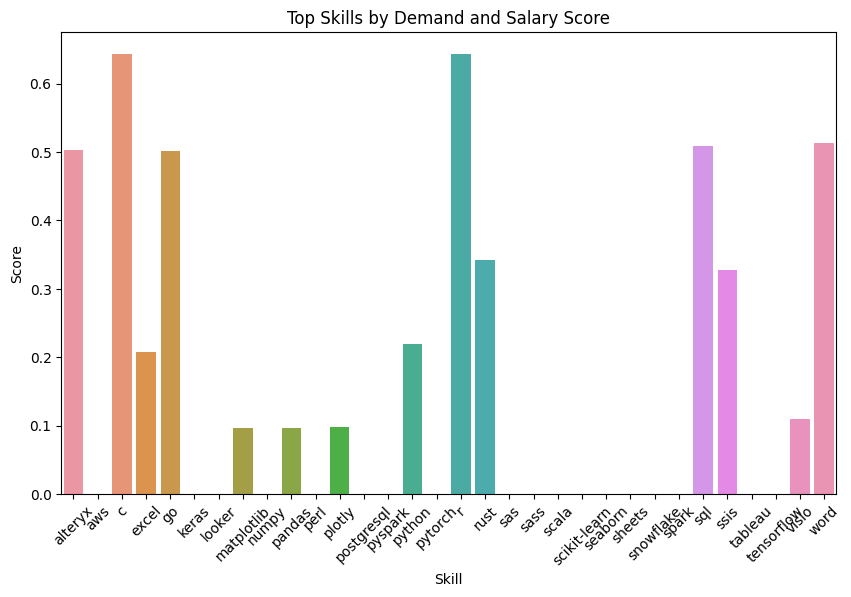

In [17]:
# Plotting the top skills by their score as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=skills_data.index, y='score', data=skills_data, order=top_skills_by_score.index, palette='viridis')
plt.title('Top Skills by Demand and Salary Score')
plt.xlabel('Skill')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()